In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import BaseHysteresis
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad

# Generate optimization data without hysteresis

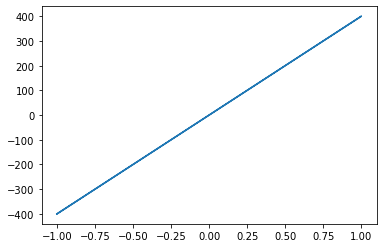

In [2]:
# Create hysteresis model
def density_function(mesh_pts, h = 0.5):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / h)


H = BaseHysteresis(
    mesh_scale = 0.1,
    trainable=False,
    fixed_domain = torch.tensor((-1.0, 1.0))
)
m_sat = 400.0
H.scale = 0.0
H.slope = (m_sat - H.scale) * 2.0
H.offset = -H.slope / 2.0

test_applied_fields = torch.cat(
    (torch.linspace(-1,1,11) , torch.flipud(torch.linspace(-1,1,11)))
)

H.regression()
M = H(test_applied_fields, return_real=True).detach()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)
H.current()

In [3]:
#create accelerator model using hysteresis models
hmodels = [deepcopy(H), deepcopy(H), deepcopy(H)]

# define quadrupoles
q1 = HysteresisQuad("q1", torch.tensor(0.01), hmodels[0])
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.01), hmodels[1])
d3 = TorchDrift("d3", torch.tensor(1.0))
q3 = HysteresisQuad("q3", torch.tensor(0.01), hmodels[2])

HA = HysteresisAccelerator([q1, d1, q2, d2, q3, d3])

init_beam_matrix = torch.eye(6) * 1.0e-8

# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0, 0] = 5.0e-3 ** 2
init_beam_matrix[1, 1] = 1.0e-4 ** 2
init_beam_matrix[2, 2] = 5.0e-3 ** 2
init_beam_matrix[3, 3] = 1.0e-4 ** 2
R = init_beam_matrix


In [4]:
# create objective function - log(sqrt(RMS()))
def objective(R):
    return torch.abs(torch.sqrt(R[0,0]) - 8e-3) + torch.abs(torch.sqrt(R[2,2]) - 8e-3)

In [5]:
from botorch.models.transforms import Normalize
# define function to create model
from gpytorch.utils.errors import NotPSDError
from botorch import fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from tqdm.notebook import trange
from gpytorch.likelihoods import GaussianLikelihood
from hysteresis.hybrid import ExactHybridGP


def get_model(train_X, train_Y, use_hybrid = False, h_models = None):
    if use_hybrid:
        gpmodel = ExactHybridGP(
            train_X.clone().detach().double(),
            train_Y.clone().detach().flatten().double(), 
            h_models,
        )
        
        mll = ExactMarginalLogLikelihood(gpmodel.gp.likelihood, gpmodel)
        fit_gpytorch_model(mll)
        
    else:
        std_trans = Standardize(1)
        gpmodel = SingleTaskGP(
            train_X.clone().detach(),
            train_Y.clone().detach(),
            input_transform=Normalize(train_X.shape[-1]),
            outcome_transform=std_trans
        )
        mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)
        fit_gpytorch_model(mll)
    return gpmodel

In [6]:
# define optimizer function


def optimize(
        accelerator_model,
        initial_beam_matrix,
        h_models,
        steps=50,
        use_hybrid = False
):
    iterations = steps

    # initialize with a couple of points
    train_x = torch.ones((3, 3)) * 0.25
    train_x[0] = train_x[0] * 0.0
    train_x[2] = torch.tensor((0.3,-0.6, 0.3))
    train_y = torch.empty((3, 1))

    accelerator_model.current()

    for j in range(len(train_x)):
        accelerator_model.apply_fields({'q1': train_x[j, 0],
                                        'q2': train_x[j, 1],
                                        'q3': train_x[j, 2],})

        beam_matrix = accelerator_model(init_beam_matrix, full=False)
        #fig,ax = plt.subplots()
        #ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
        #ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())


        train_y[j] = objective(
            accelerator_model(initial_beam_matrix)
        )

    print(train_x)
    print(train_y)

    gpmodel = get_model(train_x, train_y, use_hybrid, h_models)

    for i in trange(iterations):
        print(gpmodel.hysteresis_models[0].history_h)
        print(HA.elements['q1'].hysteresis_model.history_h)


        UCB = UpperConfidenceBound(gpmodel, beta=2.0, maximize=False)
        
        if use_hybrid:
            gpmodel.next()

        bounds = torch.stack([-1.0 * torch.ones(3), 1.0*torch.ones(3)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_x = torch.cat((train_x, candidate))

        # apply candidate
        accelerator_model.apply_fields({'q1': candidate[0,0],
                                        'q2': candidate[0,1],
                                        'q3': candidate[0,2]})

        # make next measurement
        bs = objective(
            accelerator_model(initial_beam_matrix)
        ).reshape(1, 1)
        train_y = torch.cat((train_y.clone(), bs.clone()))

        # train new model
        try:
            gpmodel = get_model(train_x, train_y, use_hybrid, h_models)
        except NotPSDError:
            pass


    
    return train_x, train_y, gpmodel

## Do optimization

In [7]:
use_hybrid = True
train_X_data, train_Y_data, model = optimize(
    HA,
    R,
    hmodels,
    steps=5,
    use_hybrid=use_hybrid
)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[0.0060],
        [0.0610],
        [0.0351]], grad_fn=<CopySlices>)


  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.0000, 0.2500, 0.3000], dtype=torch.float64)
tensor([0.0000, 0.2500, 0.3000], dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692], dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692], dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735], dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735], dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735, -0.0785],
       dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735, -0.0785],
       dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735, -0.0785,  0.0222],
       dtype=torch.float64)
tensor([ 0.0000,  0.2500,  0.3000, -0.0692, -0.0735, -0.0785,  0.0222],
       dtype=torch.float64)


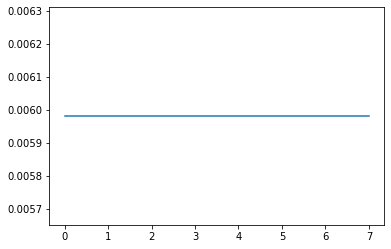

In [8]:
def get_best(input):
    out = []
    for i in range(len(input)):
        out += [torch.min(input[:i+1])]
    return torch.tensor(out)

fig,ax = plt.subplots()
best = get_best(train_Y_data.flatten().detach())
ax.plot(best)

{'q1': tensor(0.), 'q2': tensor(0.), 'q3': tensor(0.)}
tensor([-0.0735, -0.0785,  0.0222,  0.0967,  0.0000], dtype=torch.float64)
tensor([-0.0984,  0.1691, -0.2921, -0.1468,  0.0000], dtype=torch.float64)
tensor([ 0.0774,  0.0355,  0.0160, -0.0697,  0.0000], dtype=torch.float64)
tensor(0.0060, grad_fn=<AddBackward0>)
tensor(0.0060, grad_fn=<MinBackward1>)


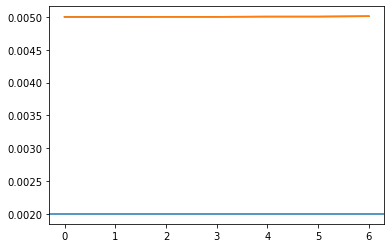

In [9]:
best_settings = train_X_data[torch.argmin(train_Y_data)]

# apply candidate
print(dict(zip(['q1','q2','q3'], best_settings)))
HA.apply_fields(dict(zip(['q1','q2','q3'], best_settings)))
print(HA.elements['q1'].hysteresis_model.history_h[-5:])
print(HA.elements['q2'].hysteresis_model.history_h[-5:])
print(HA.elements['q3'].hysteresis_model.history_h[-5:])

beam_matrix = HA(init_beam_matrix, full=False)
fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
print(objective(beam_matrix[-1]))
print(torch.min(train_Y_data))

In [10]:
model = get_model(train_X_data, train_Y_data, use_hybrid = use_hybrid, h_models = hmodels)
print(model.hysteresis_models[0].history_h[-5:])
print(HA.elements['q1'].hysteresis_model.history_h[-5:])

tensor([-0.0692, -0.0735, -0.0785,  0.0222,  0.0967], dtype=torch.float64)
tensor([-0.0692, -0.0735, -0.0785,  0.0222,  0.0967], dtype=torch.float64)


In [11]:
# optimize model to find the best point
UCB = UpperConfidenceBound(model, beta=0.01, maximize=False)
try:
    model.next()
except AttributeError:
    pass

bounds = torch.stack([-1.0 * torch.ones(3), 1.0*torch.ones(3)])
candidate, acq_value = optimize_acqf(
    UCB,
    bounds=bounds,
    q=1,
    num_restarts=100,
    raw_samples=100,
)
print(candidate)

tensor([[-0.0023, -0.1055,  0.0135]])


tensor(0.0082, grad_fn=<AddBackward0>)
tensor(0.0060, grad_fn=<MinBackward1>)


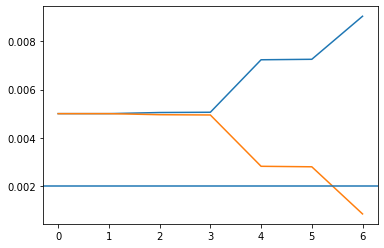

In [12]:
HA.apply_fields(dict(zip(['q1','q2','q3'], candidate.flatten())))

beam_matrix = HA(init_beam_matrix, full=False)
fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
print(objective(beam_matrix[-1]))
print(torch.min(train_Y_data))